# Problem Definition

We will attempt to predict bulldozer prices using Regression Machine Learning models.

# Data

**Data:** https://www.kaggle.com/datasets/farhanreynaldo/blue-book-for-bulldozer

**Number of Samples:**  401125

### **Features:**

**0.**   SalesID                 
**1.**   SalePrice               
**2.**   MachineID               
**3.**   ModelID                 
**4.**   datasource              
**5.**   auctioneerID            
**6.**   YearMade                
**7.**   MachineHoursCurrentMeter                                     
**8.**   UsageBand                   
**9.**   fiModelDesc                
**10.**  fiBaseModel                
**11.**  fiSecondaryDesc           
**12.**  fiModelDescriptor         
**13.**  ProductSize                 
**14.**  fiProductClassDesc          
**15.**  state                       
**16.**  ProductGroup                
**17.**  ProductGroupDesc            
**18.**  Drive_System                
**19.**  Enclosure                   
**20.**  Forks                       
**21.**  Pad_Type                    
**22.**  Ride_Control                
**23.**  Stick                       
**24.**  Transmission                
**25.**  Turbocharged                
**26.**  Hydraulics                  
**27.**  Ripper                      
**28.**  Tire_Size                   
**29.**  Coupler                     
**30.**  Track_Type                  
**31.**  Undercarriage_Pad_Width     
**32.**  Stick_Length                
**33.**  Thumb                       
**34.**  Pattern_Changer             
**35.**  Grouser_Type                
**36.**  Backhoe_Mounting            
**37.**  Blade_Type                  
**38.**  Travel_Controls             
**39.**  Differential_Type 

### **Feature Relevance:**
**Identifiers - {SalesID, MachineID, ModelID, datasource, auctioneerID}:** Tell you which model-family, data-collection pipeline, or auction house the sale came from. Different auctioneers or data sources may systematically price equipment higher or lower. Track duplicates.

**Target - {SalePrice}:** This is what you’re trying to predict. All other features should (directly or indirectly) help explain its variance.

**Age & Usage - {YearMade, MachineHoursCurrentMeter, UsageBand}:** Older machines typically fetch lower prices (depreciation). Analogous to “mileage” on a car—more hours means more wear, lower value. Pre-binned usage categories (e.g. Light, Medium, Heavy) can capture nonlinear effects of wear without modeling raw hours.

**Model & Design Specs - {fiModelDesc, fiBaseModel, fiSecondaryDesc, fiModelDescriptor, ProductSize, fiProductClassDesc, ProductGroup, ProductGroupDesc}:** Textual descriptions that detail power, chassis, or configuration variants within a model line. Different trim-levels or options can shift price significantly. Indicate machine capacity (e.g. small loader vs. large excavator), lifting or digging class—all highly price-relevant.

**Configuration & Attachments - {Drive_System, Enclosure, Transmission, Turbocharged, Hydraulics, Differential_Type, Steering_Controls, Travel_Controls, Forks, Ripper, Blade_Type, Stick, Stick_Length, Backhoe_Mounting, Thumb, Pattern_Changer, Coupler, Track_Type, Tire_Size, Undercarriage_Pad_Width, Grouser_Type, Ride_Control, Pad_Type}:** Core drivetrain and hydraulic capabilities. Optional attachments or undercarriage specs. Since we are not experts at analyzing bullodozers' price ourselves we assume that by more capabilities a bulldozer has, the higher the price might be. But that will be part of the EDA. 

**Location & Timing - {state}:** Regional demand (e.g. heavy construction states vs. agriculture-focused areas) and transport costs both influence price.

# Choosing our Libraries and Tools

## Imports

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from IPython.display import Image, display

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import KFold

## Functions

In [138]:
def show_scores(y_test, y_pred, model_name):
    print(model_name)
    print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
    print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred):.3f}")
    print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred):.3f}")
    print()

def get_scores(y_test, y_pred):
    return {
        "R2": r2_score(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
    }

def plot_actual_vs_predicted(y_true, y_pred, title='Actual vs Predicted'):
    plt.figure()
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_residuals(y_true, y_pred, title='Residual Plot'):
    residuals = y_true - y_pred
    plt.figure()
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted Price')
    plt.ylabel('Residuals')
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_residual_histogram(y_true, y_pred, title='Histogram of Residuals'):
    residuals = y_true - y_pred

    plt.figure()
    sns.histplot(residuals, kde=True)
    plt.title(title)
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

def plot_feature_importance(columns, importances, n=20, title="Feature Importances"):
    df = (
        pd.DataFrame({
            "feature": columns,
            "importance": importances
        })
        .sort_values("importance", ascending=False)
        .reset_index(drop=True)
    )
    
    fig, ax = plt.subplots()
    ax.barh(df["feature"][:n], df["importance"][:n])
    ax.set_ylabel("Feature")
    ax.set_xlabel("Importance")
    ax.invert_yaxis()        
    ax.set_title(title)           
    plt.tight_layout()
    plt.show()
    
    return fig, ax
    

# Import the data

In [139]:
# Import the data
df = pd.read_csv("Data/Train.csv/Train.csv", low_memory=False)

# Since this is a time series we want to make the 'saledate' column a date_time datatype and we preferably wnat these to be sorted.
df['saledate'] = pd.to_datetime(df['saledate'])
df.sort_values(by=["saledate"],  inplace=True, ascending=True)

# Exploratory Data Analysis

In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401125 entries, 205615 to 400217
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   401125 non-null  int64         
 1   SalePrice                 401125 non-null  int64         
 2   MachineID                 401125 non-null  int64         
 3   ModelID                   401125 non-null  int64         
 4   datasource                401125 non-null  int64         
 5   auctioneerID              380989 non-null  float64       
 6   YearMade                  401125 non-null  int64         
 7   MachineHoursCurrentMeter  142765 non-null  float64       
 8   UsageBand                 69639 non-null   object        
 9   saledate                  401125 non-null  datetime64[ns]
 10  fiModelDesc               401125 non-null  object        
 11  fiBaseModel               401125 non-null  object        
 12  fi

## Data Visualization

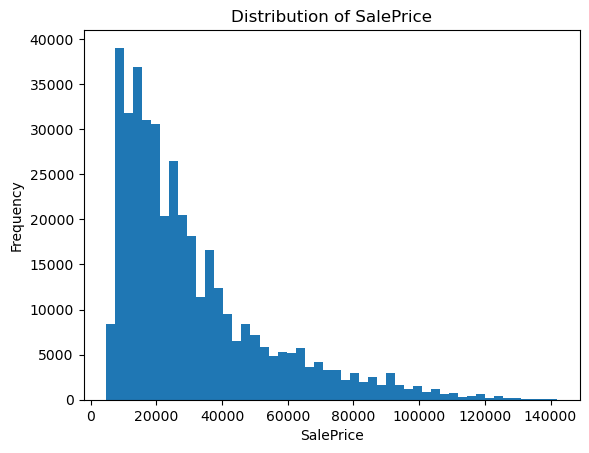

In [141]:
plt.figure()
plt.hist(df['SalePrice'].dropna(), bins=50)
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

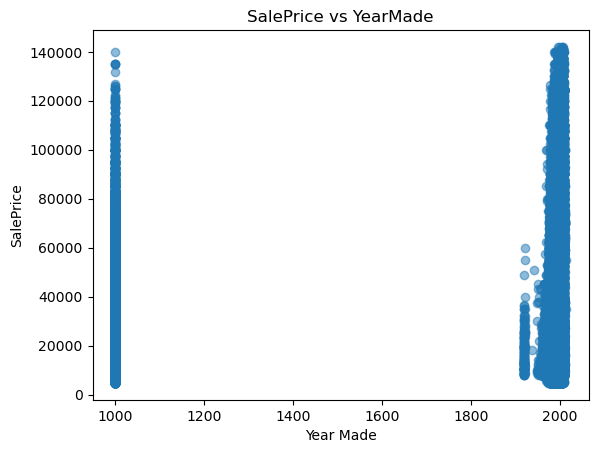

In [142]:
plt.figure()
plt.scatter(df['YearMade'], df['SalePrice'], alpha=0.5)
plt.title('SalePrice vs YearMade')
plt.xlabel('Year Made')
plt.ylabel('SalePrice')
plt.show()

This graph shows that there were some Bulldozers made in the year 1000. Which brought this question on why this might be the case. Then we try to see when was the first bulldozer built, and according to Wikipedia "These appeared as early as 1929" so we just decided to overlook this fact for now. 

But we will print all the unieque values to make sure there is not another extraneous value like that in the dataset. 

In [143]:
# allow printing all rows
pd.set_option('display.max_rows', None)

# now this will print every YearMade value and its count
print(df["YearMade"].value_counts())

# (optionally) reset to default
pd.reset_option('display.max_rows')

YearMade
1000    38185
1998    21221
2005    20587
2004    20020
1997    18905
1999    18767
2000    16742
1996    16691
1995    15528
1994    14199
2003    14161
2001    12938
2006    12215
2002    12031
1993    10971
1989    10693
1988    10395
1990    10250
1987    10105
1992     7587
1986     7508
1991     7361
1985     6475
1984     6111
1978     5623
1979     5557
1980     4677
1983     4557
2007     4523
1977     4379
1981     4144
1975     3192
1974     3079
1982     3018
1976     2694
1973     2521
1972     2119
1971     1705
1969     1529
2008     1422
1970     1314
1968     1247
1967     1086
1966      943
1965      667
1964      414
1963      246
2009      168
1962      143
1919      127
1961       99
1960       97
1959       28
2010       25
1958       22
1956       20
2011       18
1920       17
1957       15
1950        8
1951        7
1953        6
1952        6
1955        5
1954        3
1948        3
1942        1
1937        1
1949        1
1947        1
2012       

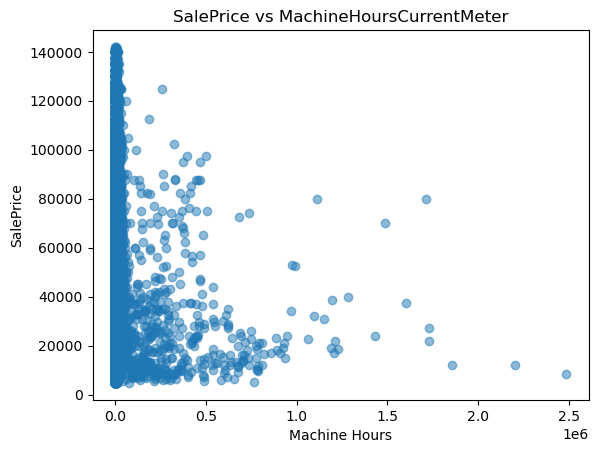

In [144]:
plt.figure()
plt.scatter(df['MachineHoursCurrentMeter'], df['SalePrice'], alpha=0.5)
plt.title('SalePrice vs MachineHoursCurrentMeter')
plt.xlabel('Machine Hours')
plt.ylabel('SalePrice')
plt.show()

This graph not only shows that the usage of the bulldozer matters, but also shows how the data set is populated by mostly brand new bulldozers.

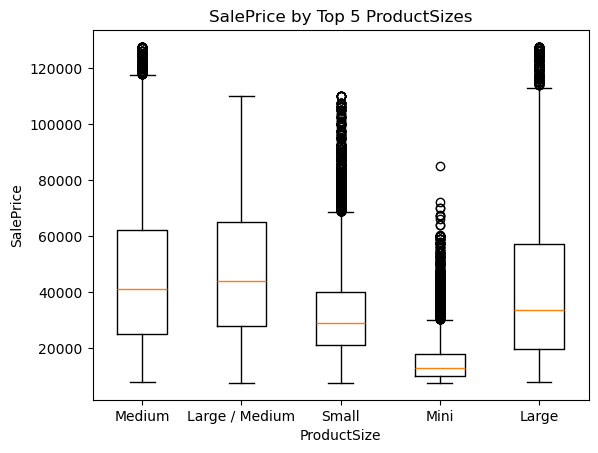

In [145]:
top_sizes = df['ProductSize'].value_counts().nlargest(5).index
data = [df[df['ProductSize']==size]['SalePrice'].dropna() for size in top_sizes]

plt.figure()
plt.boxplot(data, labels=top_sizes)
plt.title('SalePrice by Top 5 ProductSizes')
plt.xlabel('ProductSize')
plt.ylabel('SalePrice')
plt.show()

## Data Cleaning

In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401125 entries, 205615 to 400217
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   401125 non-null  int64         
 1   SalePrice                 401125 non-null  int64         
 2   MachineID                 401125 non-null  int64         
 3   ModelID                   401125 non-null  int64         
 4   datasource                401125 non-null  int64         
 5   auctioneerID              380989 non-null  float64       
 6   YearMade                  401125 non-null  int64         
 7   MachineHoursCurrentMeter  142765 non-null  float64       
 8   UsageBand                 69639 non-null   object        
 9   saledate                  401125 non-null  datetime64[ns]
 10  fiModelDesc               401125 non-null  object        
 11  fiBaseModel               401125 non-null  object        
 12  fi

In [147]:
# Since some of the features are missing a lot of data we drop all of the columns that have at least 85% null values.
missing_percent = df.isnull().sum() / len(df)
columns_to_drop = missing_percent[missing_percent > 0.85].index
df.drop(columns=columns_to_drop, axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401125 entries, 205615 to 400217
Data columns (total 42 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   401125 non-null  int64         
 1   SalePrice                 401125 non-null  int64         
 2   MachineID                 401125 non-null  int64         
 3   ModelID                   401125 non-null  int64         
 4   datasource                401125 non-null  int64         
 5   auctioneerID              380989 non-null  float64       
 6   YearMade                  401125 non-null  int64         
 7   MachineHoursCurrentMeter  142765 non-null  float64       
 8   UsageBand                 69639 non-null   object        
 9   saledate                  401125 non-null  datetime64[ns]
 10  fiModelDesc               401125 non-null  object        
 11  fiBaseModel               401125 non-null  object        
 12  fi

In [148]:
# Scale the numerical values so the ones with higher magnitdes won't affect the proportion of relevance at the time of fitting.

scaler = StandardScaler()
numeric_cols = df.select_dtypes(include=['int64','float64','int32']).columns
scaled = scaler.fit_transform(df[numeric_cols])
df_scaled = pd.DataFrame(scaled, index=df.index, columns=numeric_cols)
df[numeric_cols] = df_scaled

df

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,-0.300260,-0.937615,-0.207577,0.248209,-0.297450,0.674096,0.256490,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
92803,-0.567307,-0.308189,-0.108851,0.035407,-0.297450,5.445325,0.297615,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98346,-0.554516,0.169306,0.100196,-0.567797,-0.297450,5.445325,0.259917,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
169297,-0.355718,-0.525233,0.488278,0.218153,-0.297450,5.445325,0.270198,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
274835,-0.108027,-0.742276,-0.054000,0.524014,-0.297450,5.445325,0.277052,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393123,4.775653,-0.763980,1.319054,-0.448056,1.599401,-0.268369,-3.081446,NaN,NaN,2011-12-30,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN
397987,4.805903,-0.926763,1.484595,-0.323815,1.599401,-0.268369,-3.081446,NaN,NaN,2011-12-30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
392664,4.772589,-0.720572,1.495835,-0.597853,1.599401,-0.268369,0.304469,NaN,NaN,2011-12-30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
400458,4.835811,-0.807389,1.477885,3.144812,1.599401,-0.268369,0.379864,NaN,NaN,2011-12-30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional


In [149]:
# Converting object-typed features into categories
for label, content in df.items():
    if pd.api.types.is_object_dtype(content):
        df[label] = content.astype("category").cat.as_ordered()

# Fill in numerical missing values with median 
num_cols = df.select_dtypes(include=['number']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Convert Categories in to numerical values
for label, content in df.items():
    if not pd.api.types.is_numeric_dtype(content):
        df[label] = pd.Categorical(content).codes + 1

df = df.reset_index(drop=True)
       
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 42 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   401125 non-null  float64
 1   SalePrice                 401125 non-null  float64
 2   MachineID                 401125 non-null  float64
 3   ModelID                   401125 non-null  float64
 4   datasource                401125 non-null  float64
 5   auctioneerID              401125 non-null  float64
 6   YearMade                  401125 non-null  float64
 7   MachineHoursCurrentMeter  401125 non-null  float64
 8   UsageBand                 401125 non-null  int8   
 9   saledate                  401125 non-null  int16  
 10  fiModelDesc               401125 non-null  int16  
 11  fiBaseModel               401125 non-null  int16  
 12  fiSecondaryDesc           401125 non-null  int16  
 13  fiModelDescriptor         401125 non-null  i

# Data Fitting & Tuning

In [150]:
# split the data train-test (80-20%)
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Model Fitting **WITHOUT** GridSearchCV

### Linear Regression Model

In [151]:
start = time.time()

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

end = time.time()
print(f"Training time: {end - start:.2f} seconds")

Training time: 0.50 seconds


### Lasso

In [152]:
start = time.time()

lasso = Lasso(alpha=1.0, random_state=42, max_iter=10000)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)

end = time.time()
print(f"Training time: {end - start:.2f} seconds")

Training time: 0.31 seconds


### Elastic Net

In [153]:
start = time.time()

elastic = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42, max_iter=10000)
elastic.fit(X_train, y_train)
elastic_pred = elastic.predict(X_test)

end = time.time()
print(f"Training time: {end - start:.2f} seconds")

Training time: 0.46 seconds


### Decision Tree Regression Model

In [154]:
start = time.time()

dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)

end = time.time()
print(f"Training time: {end - start:.2f} seconds")

Training time: 7.73 seconds


### K-Nearest Neighbors Regression Model

In [155]:
start = time.time()

knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

end = time.time()
print(f"Training time: {end - start:.2f} seconds")

Training time: 99.20 seconds


### Random Forest Regressor

In [156]:
start = time.time()

rfr_model = RandomForestRegressor(n_jobs=-1,
                                  random_state=42)
rfr_model.fit(X_train, y_train)
rfr_pred = rfr_model.predict(X_test)

end = time.time()
print(f"Training time: {end - start:.2f} seconds")

Training time: 173.97 seconds


## Evaluation **WITHOUT** GridSearchCV

In [157]:
show_scores(y_test, lr_pred, "Linear Regression Model")
show_scores(y_test, lasso_pred, "Lasso")
show_scores(y_test, elastic_pred, "Elastic Net")
show_scores(y_test, dt_pred, "Decision Tree Regression Model")
show_scores(y_test, knn_pred, "K-Nearest Neighbors")
show_scores(y_test, rfr_pred, "Random Forest Regressor")

Linear Regression Model
R² Score: 0.392
Mean Squared Error (MSE): 0.612
Mean Absolute Error (MAE): 0.559

Lasso
R² Score: 0.136
Mean Squared Error (MSE): 0.869
Mean Absolute Error (MAE): 0.693

Elastic Net
R² Score: 0.180
Mean Squared Error (MSE): 0.825
Mean Absolute Error (MAE): 0.667

Decision Tree Regression Model
R² Score: 0.826
Mean Squared Error (MSE): 0.175
Mean Absolute Error (MAE): 0.251

K-Nearest Neighbors
R² Score: 0.680
Mean Squared Error (MSE): 0.322
Mean Absolute Error (MAE): 0.354

Random Forest Regressor
R² Score: 0.909
Mean Squared Error (MSE): 0.092
Mean Absolute Error (MAE): 0.188



Since Linear Regression, Lasso and ElasticNet did not do good we will discard them and only continue Decision Tree, K-Nearest Neighbors and Random Forest Regressor models.

## Visual Evaluation Metrics **WITHOUT** GridSearchCV

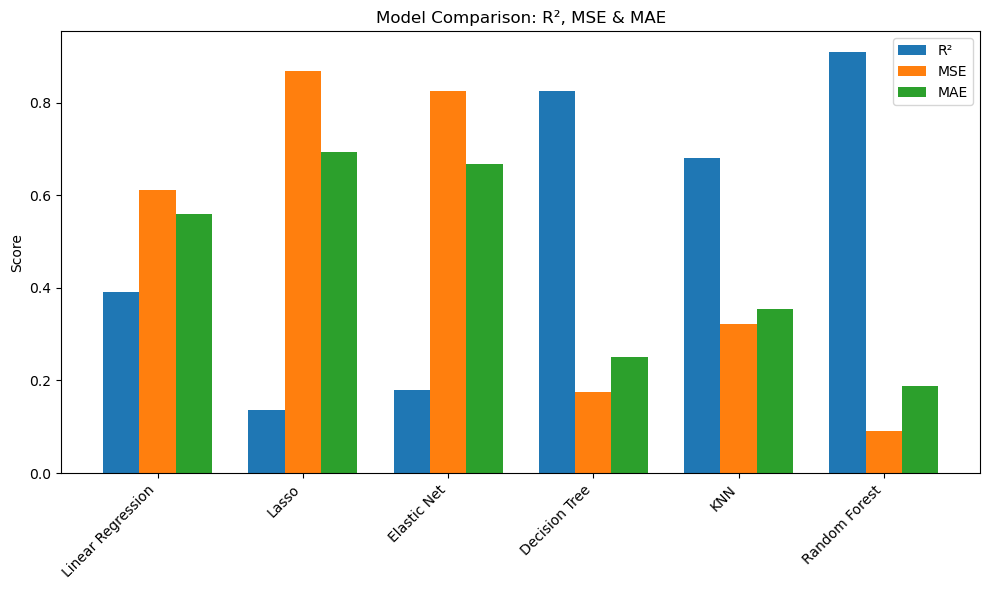

In [158]:
models = [
    "Linear Regression",
    "Lasso",
    "Elastic Net",
    "Decision Tree",
    "KNN",
    "Random Forest"
]
preds = [
    lr_pred,
    lasso_pred,
    elastic_pred,
    dt_pred,
    knn_pred,
    rfr_pred
]

r2_scores  = [r2_score(y_test, pred) for pred in preds]
mse_scores = [mean_squared_error(y_test, pred) for pred in preds]
mae_scores = [mean_absolute_error(y_test, pred) for pred in preds]

x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width, r2_scores,  width, label="R²")
ax.bar(x,         mse_scores, width, label="MSE")
ax.bar(x + width, mae_scores, width, label="MAE")

ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha="right")
ax.set_ylabel("Score")
ax.set_title("Model Comparison: R², MSE & MAE")
ax.legend()
plt.tight_layout()
plt.show()

## Model Fitting **With** GridSearchCV

### Decision Tree Regression Model (GridSearchCV)

In [159]:
start = time.time()

param_grid_dt = {
    'max_depth': [10, 20, 30],
    'min_samples_split': [5, 10, 15],
    'criterion': ['squared_error', 'friedman_mse']
}

grid_dt = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid_dt,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_dt.fit(X_train, y_train)
end = time.time()

print("Best DT parameters:", grid_dt.best_params_)
print(f"Grid search took {(end - start):.2f} seconds")

dt_best = grid_dt.best_estimator_
dt_pred_gs = dt_best.predict(X_test)

Best DT parameters: {'criterion': 'squared_error', 'max_depth': 20, 'min_samples_split': 15}
Grid search took 134.14 seconds


### K-Nearest Neighbors Regression Model (GridSearchCV)

In [160]:
start = time.time()

param_grid_knn = {
    'n_neighbors': [7, 9],
    'weights':     ['uniform', 'distance']
}

grid_knn = GridSearchCV(
    KNeighborsRegressor(),
    param_grid_knn,
    cv=5,
    scoring='neg_root_mean_squared_error',  # directly gives negative RMSE
    n_jobs=-1
)

grid_knn.fit(X_train, y_train)
end = time.time()

best_knn = grid_knn.best_estimator_
print("Best KNN parameters:", grid_knn.best_params_)
print(f"Grid search took {(end - start)/60:.2f} minutes")

knn_pred_gs = best_knn.predict(X_test)

Best KNN parameters: {'n_neighbors': 7, 'weights': 'distance'}
Grid search took 17.48 minutes


### Random Forest Regression Model (GridSearchCV)

In [161]:
start = time.time()

param_rfr_grid = {
    "n_estimators":   np.arange(40, 70, 10),
    "min_samples_split": np.arange(12, 16, 2),
    "min_samples_leaf":  np.arange(1, 5, 2),
    "max_features":   [0.5, "sqrt", "auto"],
    "max_samples":    [10000]
}

grid_rfr = GridSearchCV(
    estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
    param_grid=param_rfr_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_rfr.fit(X_train, y_train)
end = time.time()

print("Best RF parameters:", grid_rfr.best_params_)
print(f"Grid search took {(end - start):.2f} seconds")

best_rfr = grid_rfr.best_estimator_
rfr_pred_gs = best_rfr.predict(X_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best RF parameters: {'max_features': 0.5, 'max_samples': 10000, 'min_samples_leaf': np.int64(1), 'min_samples_split': np.int64(12), 'n_estimators': np.int64(60)}
Grid search took 205.50 seconds


## Evaluation Metrics **WITH** GridSearchCV

In [162]:
show_scores(y_test, dt_pred_gs, "Decision Tree Regression Model (GridSearchCV)")
show_scores(y_test, knn_pred_gs, "K-Nearest Neighbors (GridSearchCV)")
show_scores(y_test, rfr_pred_gs, "Random Forest Regressor (GridSearchCV)")

Decision Tree Regression Model (GridSearchCV)
R² Score: 0.861
Mean Squared Error (MSE): 0.140
Mean Absolute Error (MAE): 0.230

K-Nearest Neighbors (GridSearchCV)
R² Score: 0.724
Mean Squared Error (MSE): 0.277
Mean Absolute Error (MAE): 0.321

Random Forest Regressor (GridSearchCV)
R² Score: 0.845
Mean Squared Error (MSE): 0.156
Mean Absolute Error (MAE): 0.257



### Main Metrics

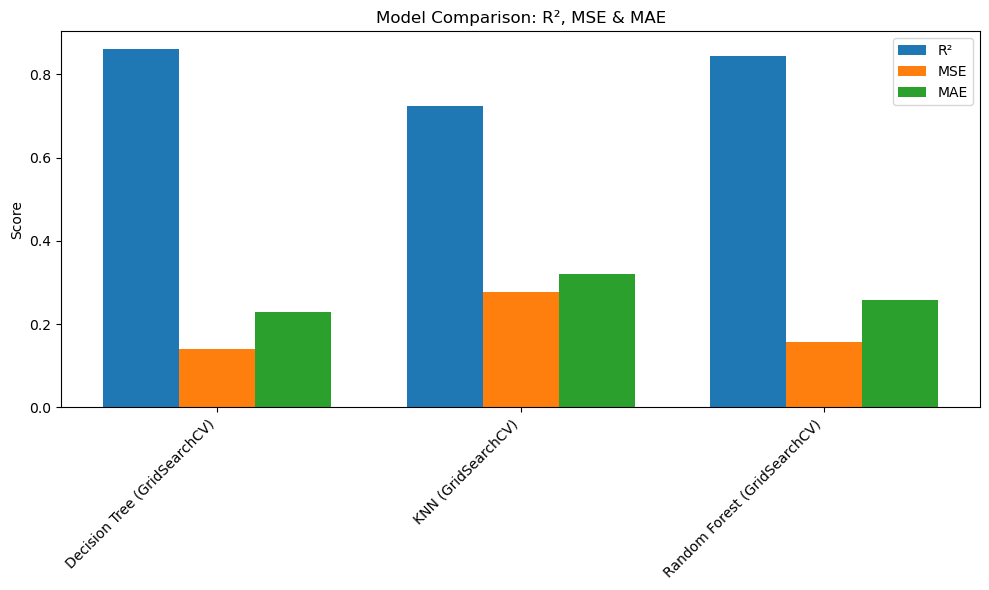

In [163]:
models = [
    "Decision Tree (GridSearchCV)",
    "KNN (GridSearchCV)",
    "Random Forest (GridSearchCV)"
]
preds = [
    dt_pred_gs,
    knn_pred_gs,
    rfr_pred_gs
]

r2_scores  = [r2_score(y_test, pred) for pred in preds]
mse_scores = [mean_squared_error(y_test, pred) for pred in preds]
mae_scores = [mean_absolute_error(y_test, pred) for pred in preds]

x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width, r2_scores,  width, label="R²")
ax.bar(x,         mse_scores, width, label="MSE")
ax.bar(x + width, mae_scores, width, label="MAE")

ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha="right")
ax.set_ylabel("Score")
ax.set_title("Model Comparison: R², MSE & MAE")
ax.legend()
plt.tight_layout()
plt.show()

### Actual vs Predicted Plot (Regression Plot)

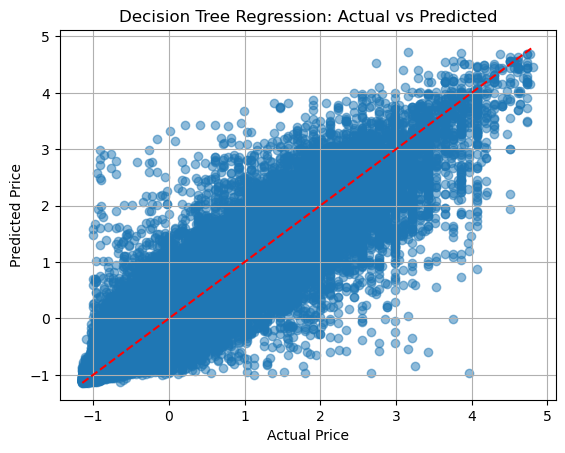

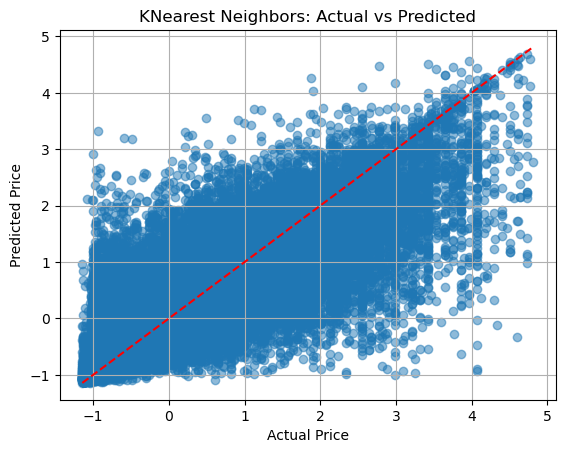

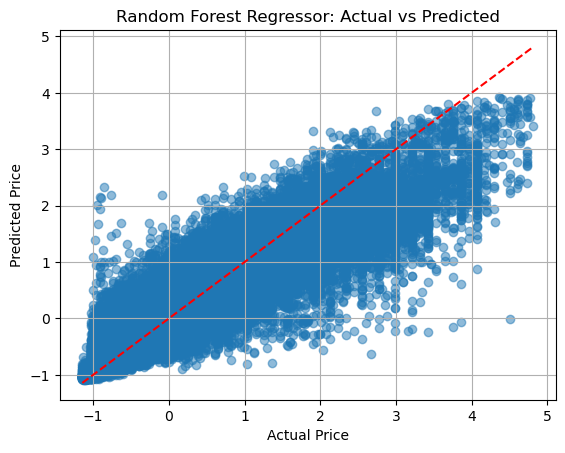

In [164]:
plot_actual_vs_predicted(y_test, dt_pred_gs, 'Decision Tree Regression: Actual vs Predicted')
plot_actual_vs_predicted(y_test, knn_pred_gs, 'KNearest Neighbors: Actual vs Predicted')
plot_actual_vs_predicted(y_test, rfr_pred_gs, 'Random Forest Regressor: Actual vs Predicted')

### Residual Plot (Errors in Predicted Price)

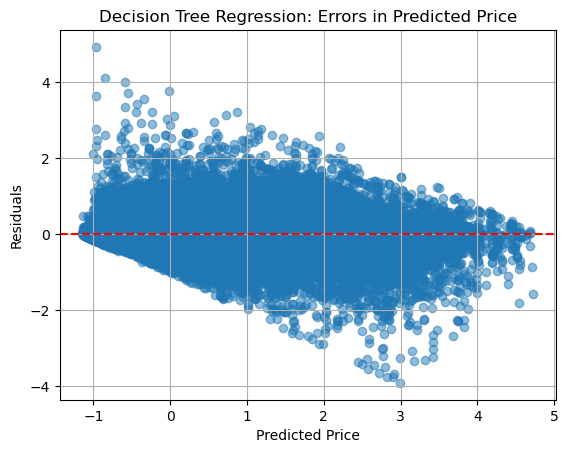

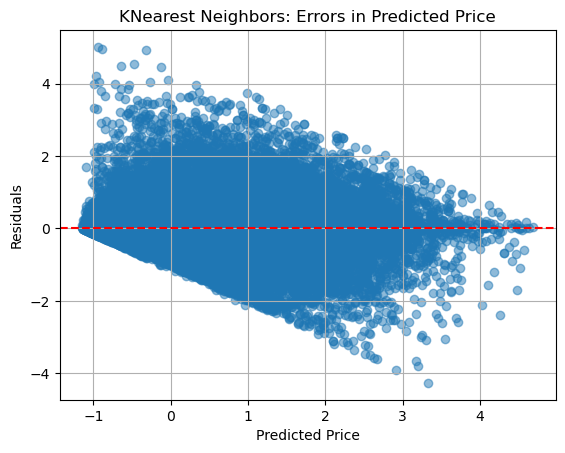

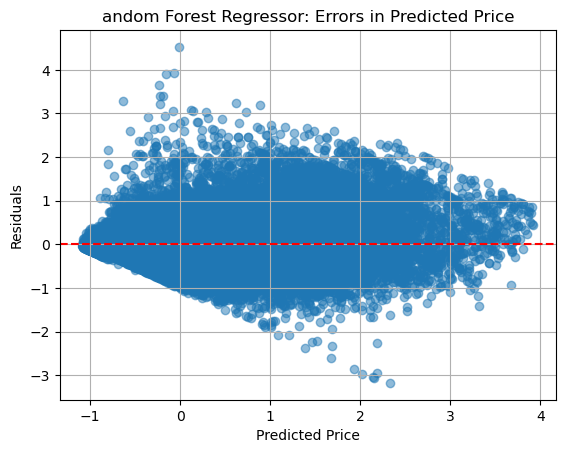

In [165]:
plot_residuals(y_test, dt_pred_gs, 'Decision Tree Regression: Errors in Predicted Price')
plot_residuals(y_test, knn_pred_gs, 'KNearest Neighbors: Errors in Predicted Price')
plot_residuals(y_test, rfr_pred_gs, 'andom Forest Regressor: Errors in Predicted Price')

### Residual Histogram Plot (Distribution of Errors)

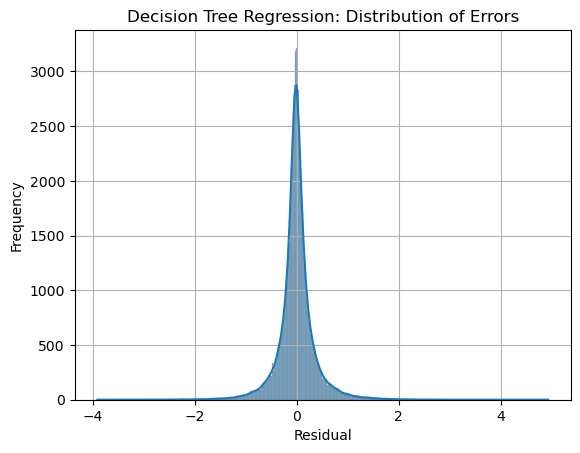

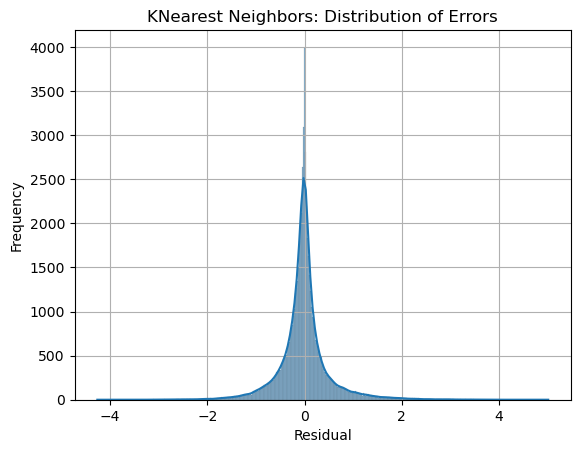

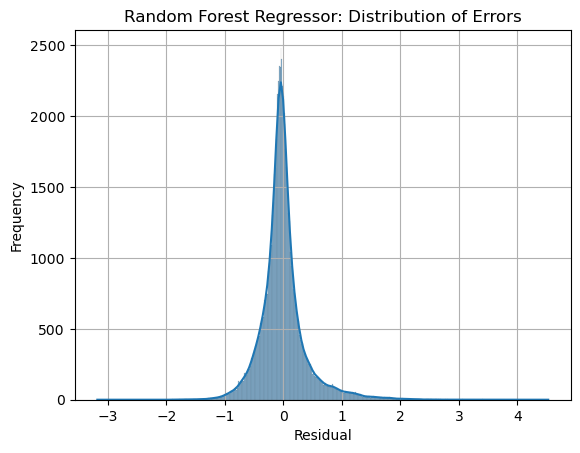

In [166]:
plot_residual_histogram(y_test, dt_pred_gs, 'Decision Tree Regression: Distribution of Errors')
plot_residual_histogram(y_test, knn_pred_gs, 'KNearest Neighbors: Distribution of Errors')
plot_residual_histogram(y_test, rfr_pred_gs, 'Random Forest Regressor: Distribution of Errors')

### Feature Importance

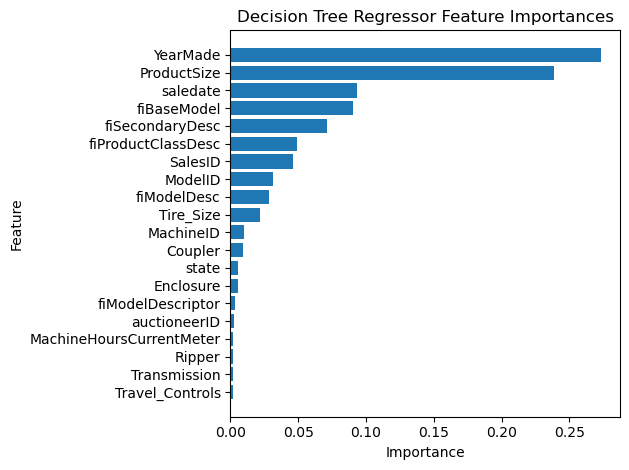

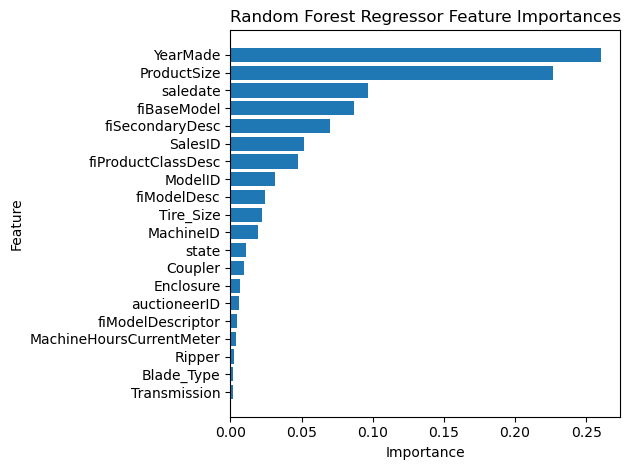

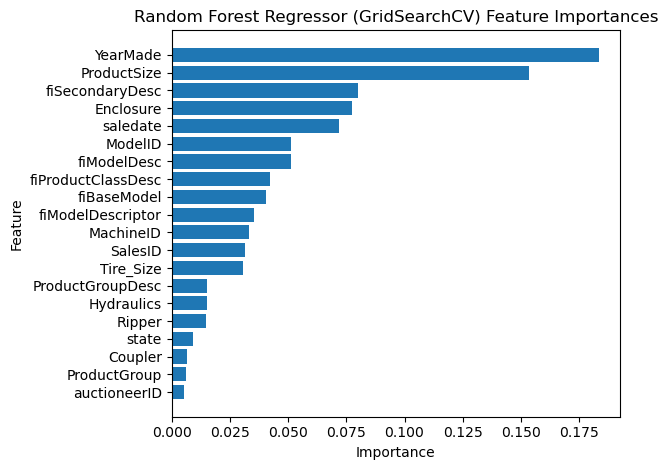

In [167]:
plot_feature_importance(X.columns, dt_best.feature_importances_, n=20, title="Decision Tree Regressor Feature Importances");
plot_feature_importance(X.columns, rfr_model.feature_importances_, n=20, title="Random Forest Regressor Feature Importances");
plot_feature_importance(X.columns, best_rfr.feature_importances_, n=20, title="Random Forest Regressor (GridSearchCV) Feature Importances");

# Conclusion

## Why we chose these models?

To choose our models we adressed the ScikitLearn Algorithm Cheatsheet: https://scikit-learn.org/stable/machine_learning_map.html

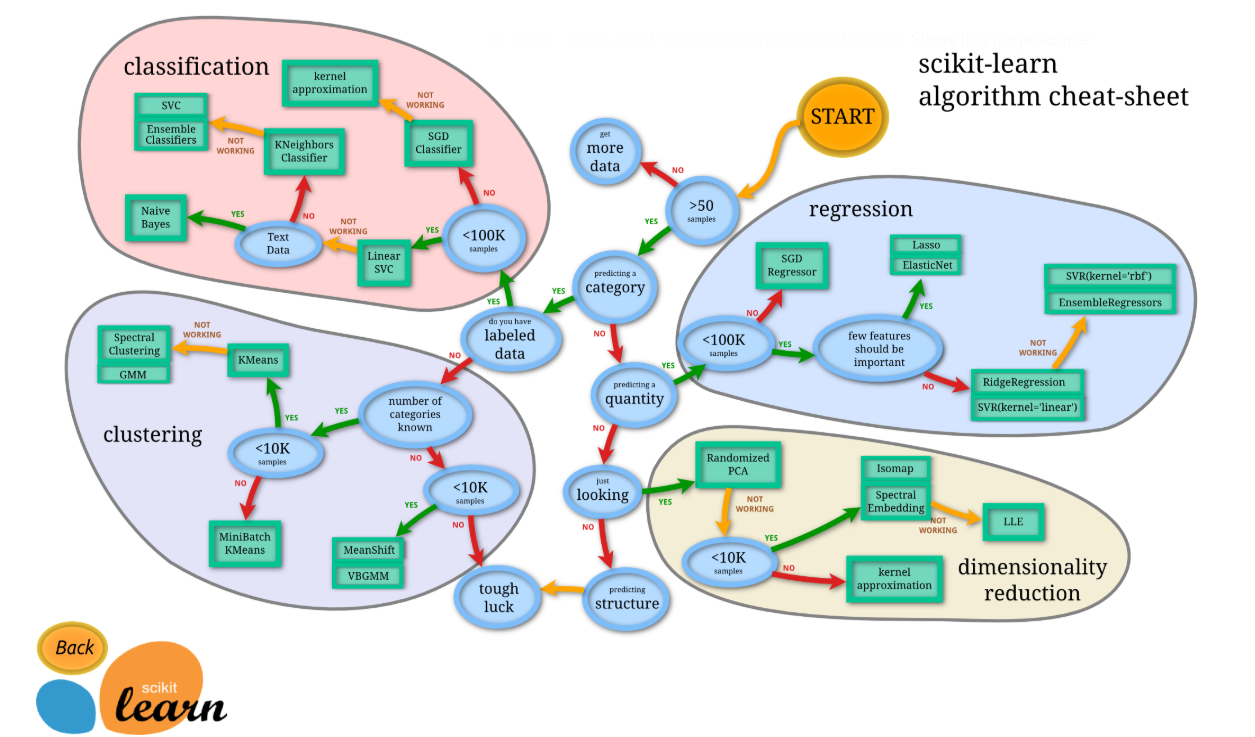

In [168]:
display(Image(filename='images/Cheatsheet.png'))

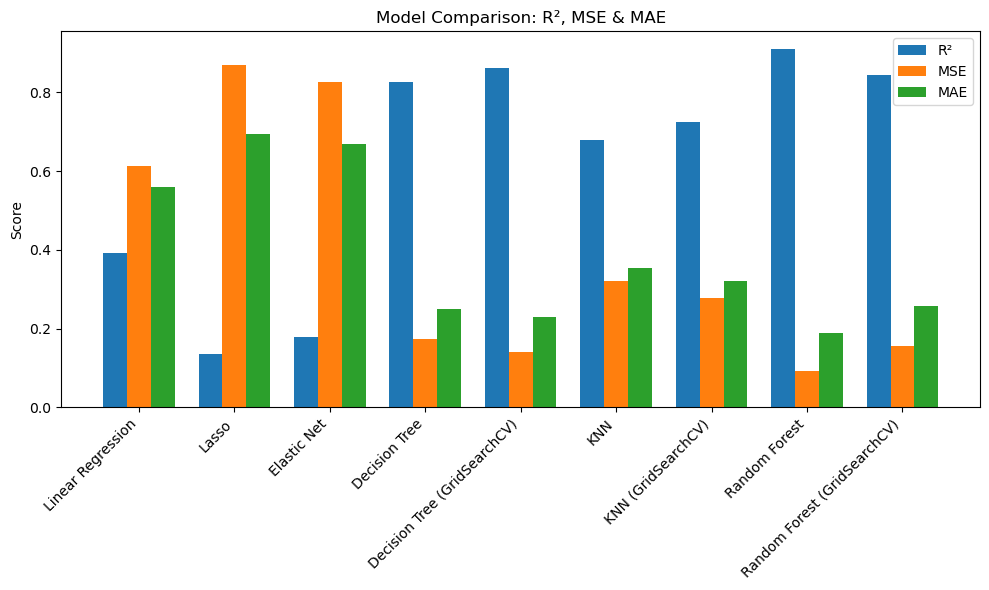

In [169]:
models = [
    "Linear Regression",
    "Lasso",
    "Elastic Net",
    "Decision Tree",
    "Decision Tree (GridSearchCV)",
    "KNN",
    "KNN (GridSearchCV)",
    "Random Forest",
    "Random Forest (GridSearchCV)"
]
preds = [
    lr_pred,
    lasso_pred,
    elastic_pred,
    dt_pred, 
    dt_pred_gs,
    knn_pred, 
    knn_pred_gs,
    rfr_pred, 
    rfr_pred_gs
]

r2_scores  = [r2_score(y_test, pred) for pred in preds]
mse_scores = [mean_squared_error(y_test, pred) for pred in preds]
mae_scores = [mean_absolute_error(y_test, pred) for pred in preds]

x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width, r2_scores,  width, label="R²")
ax.bar(x,         mse_scores, width, label="MSE")
ax.bar(x + width, mae_scores, width, label="MAE")

ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha="right")
ax.set_ylabel("Score")
ax.set_title("Model Comparison: R², MSE & MAE")
ax.legend()
plt.tight_layout()
plt.show()

In [170]:
show_scores(y_test, lr_pred, "Linear Regression Model")
show_scores(y_test, lasso_pred, "Lasso")
show_scores(y_test, elastic_pred, "Elastic Net")
show_scores(y_test, dt_pred, "Decision Tree Regression Model")
show_scores(y_test, dt_pred_gs, "Decision Tree Regression Model (GridSearchCV)")
show_scores(y_test, knn_pred, "K-Nearest Neighbors")
show_scores(y_test, knn_pred_gs, "K-Nearest Neighbors (GridSearchCV)")
show_scores(y_test, rfr_pred, "Random Forest Regressor")
show_scores(y_test, rfr_pred_gs, "Random Forest Regressor (GridSearchCV)")

Linear Regression Model
R² Score: 0.392
Mean Squared Error (MSE): 0.612
Mean Absolute Error (MAE): 0.559

Lasso
R² Score: 0.136
Mean Squared Error (MSE): 0.869
Mean Absolute Error (MAE): 0.693

Elastic Net
R² Score: 0.180
Mean Squared Error (MSE): 0.825
Mean Absolute Error (MAE): 0.667

Decision Tree Regression Model
R² Score: 0.826
Mean Squared Error (MSE): 0.175
Mean Absolute Error (MAE): 0.251

Decision Tree Regression Model (GridSearchCV)
R² Score: 0.861
Mean Squared Error (MSE): 0.140
Mean Absolute Error (MAE): 0.230

K-Nearest Neighbors
R² Score: 0.680
Mean Squared Error (MSE): 0.322
Mean Absolute Error (MAE): 0.354

K-Nearest Neighbors (GridSearchCV)
R² Score: 0.724
Mean Squared Error (MSE): 0.277
Mean Absolute Error (MAE): 0.321

Random Forest Regressor
R² Score: 0.909
Mean Squared Error (MSE): 0.092
Mean Absolute Error (MAE): 0.188

Random Forest Regressor (GridSearchCV)
R² Score: 0.845
Mean Squared Error (MSE): 0.156
Mean Absolute Error (MAE): 0.257



### Linear vs. Regularized Linear Models
    Plain Linear Regression achieved modest predictive power (R² ≈ 0.39) but relatively high errors (MSE ≈ 0.61, MAE ≈ 0.56).
    Introducing L1 (Lasso) or combined L1/L2 (Elastic Net) penalties degraded performance further (R² dropped to 0.14–0.18, MSE rose to 0.83–0.87, MAE to 0.69–0.67).
    This suggests that a simple linear relationship between features and price is too weak, and that aggressive coefficient shrinkage may be removing genuinely informative predictors.

### Tree-Based Models
    An un-tuned Decision Tree already captures nonlinearities and interactions, yielding strong performance (R² ≈ 0.83, MSE ≈ 0.18, MAE ≈ 0.25).
    Random Forests further boost stability and generalization—plain RF tops the list with R² ≈ 0.91, MSE ≈ 0.09, MAE ≈ 0.19.
    GridSearchCV tuning on the tree model nudged R² even higher (to ≈ 0.86) and reduced errors slightly (MSE ≈ 0.14, MAE ≈ 0.23), confirming that modest hyperparameter optimization can refine split depths and sample-size choices.
    Interestingly, RF tuning in this case lowered R² (from 0.91 to 0.85) and raised errors, indicating that the default RF settings may already have been near-optimal—or that the chosen parameter grid was too narrow or mismatched.

### K-Nearest Neighbors
    KNN shows decent nonlinear fitting (R² ≈ 0.72, MSE ≈ 0.28, MAE ≈ 0.32), but it lags behind tree methods in capturing complex feature interactions.
    Grid search brings negligible improvement, reaffirming that its performance is less sensitive to k and weights in this range.

# Analysis and Reflection

## Opportunities for Further Improvement

**Deepen Tree-Based Model Tuning:** Since our strongest performers were the Decision Tree and Random Forest models, dedicating more time to fine-tuning their hyperparameters (for example, expanding the GridSearchCV parameter ranges and exploring deeper trees or different splitting criteria) could yield even better results.

**Expand Random Forest Hyperparameter Search:** Given that the default Random Forest settings outperformed our initial grid search, running a broader or more targeted search—perhaps with additional n_estimators, varied max_features, or alternative sampling strategies—would help confirm whether defaults were truly optimal or simply outside our initial parameter bounds.

**Feature Selection for KNN:** To enhance the KNN model’s performance, we could implement wrapper-based feature selection (e.g., backward elimination or forward selection). Reducing irrelevant or noisy features may improve accuracy and reduce computation time.

**Explore Additional Ensemble Techniques:** Beyond Random Forests, investigating gradient-boosted trees (e.g. XGBoost, LightGBM) or stacking ensembles could capture complementary strengths of multiple base learners.

**Test Neural Network Architectures:** While tree-based methods excelled, experimenting with deep learning models (e.g. multilayer perceptrons with appropriate regularization and early stopping) might uncover nonlinear patterns that tree ensembles miss.

## Project Limitations and Challenges

**Time and Compute Constraints:** Conducting an exhaustive grid search for the Random Forest over a wide hyperparameter space required over 12 hours of runtime—highlighting the balance between exploration depth and available computational resources.

## Team Roles and Contributions

We all worked on the notebook equally and we all tackled each section as group. 
As obstacles arose, we assigned specialized roles to streamline our workflow and ensure project momentum:

**Diego Stecca — Team Leader:** 

    Oversaw project direction, coordinated overall progress, and facilitated problem-solving discussions during team meetings.

**Daniel Lipszyc — Viceleader:** 

    Supported Diego in managing tasks, maintained meeting agendas, and stepped in to guide technical discussions when needed.

**Meynard Guillermo — Meeting Coordinator:** 

    Organized and scheduled focused sub-team sessions (2–3 members) to tackle discrete milestones; this approach maintained daily progress and made collaboration efficient and enjoyable.

**Danilo Inestroza — Data Storyteller:** 

    Transformed our Jupyter Notebook into a clear, narrative-driven report by reorganizing headings, adding concise explanations, and designing illustrative visuals, making complex results accessible to non-technical stakeholders.

**Carlos Felipe — Wall Breaker:** 

    Led investigative efforts whenever we encountered blockers—debugging lengthy GridSearchCV runs, identifying performance bottlenecks, and sourcing advanced techniques to improve model accuracy.

## Contributions

**Wednesday 23rd at 9:00-11:00am** - Diego, Meynard, Carlos - Data Clean Up

**Thursday 24th at 4:00-5:00pm** - Daniel, Danilo, Meynard - Fitting and Tuning

**Friday 25th at 12:00-2:00pm** - Diego, Danilo, Daniel - Evaluation

**Saturday 26th at 9:00-11:00am** - Carlos, Diego, Danilo- Feedback Implementation, Documentation, Tidy Up

**Monday 28th at 3:00-4:00pm:** - Diego and Carlos - GridSearchCV and Ensemble Models

**Tuesday 29th at 10:00-11:30am:** - Meynard and Daniel - Look into implementing some other Evaluation metrics besides those that we already have.

**Tuesday 29th at 3:00-5:00pm:** - Carlos and Danilo - Evaluation Metrics + Visuals Comparing Evluation Metrics.

**Wednesday 30th at 11:30am-1:00pm:** - Diego and Meynard - Feature Importance and Feature Comparison. 

**Thursday 1st at 12:00-1:30pm:** - Danilo and Daniel - Tidy Up, Add Comments where needed, State conclusions and Submit. 